In [37]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [38]:
TRAIN_IMG_DIR = r"F:\DL_Projects\image_segmentation\dataset\dataset\validation\images"
TRAIN_MASK_DIR = r"F:\DL_Projects\image_segmentation\dataset\dataset\validation\masks"
TEST_IMG_DIR  = r"F:\DL_Projects\image_segmentation\dataset\dataset\test\images"
TEST_MASK_DIR = r"F:\DL_Projects\image_segmentation\dataset\dataset\test\masks"

IMG_HEIGHT = 256
IMG_WIDTH  = 256
N_CHANNELS = 3   # RGB images
BATCH_SIZE = 4
EPOCHS = 5

BATCH_SIZE = 4
EPOCHS = 8


In [39]:
# Read image
def read_image(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=N_CHANNELS)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Read mask (assumes single-channel mask with 0/255 or 0/1)
def read_mask(path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    mask = tf.io.read_file(path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, target_size)
    mask = mask = tf.cast(mask > 127, tf.float32)
    # If mask is 0/255 -> convert to 0/1
    mask = tf.where(mask > 127, 1.0, 0.0)
    return mask

# Data augmentation (flip, rotate, brightness etc.)
def augment(img, mask):
    # Random flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (90 degrees) – simple & safe
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # Random brightness
    img = tf.image.random_brightness(img, max_delta=0.2)

    return img, mask



In [40]:
# Create sorted file lists so image[i] matches mask[i]
train_image_paths = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, "*")))
train_mask_paths  = sorted(glob.glob(os.path.join(TRAIN_MASK_DIR, "*")))

test_image_paths  = sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*")))
test_mask_paths   = sorted(glob.glob(os.path.join(TEST_MASK_DIR, "*")))

print("Train images:", len(train_image_paths))
print("Train masks :", len(train_mask_paths))
print("Test images :", len(test_image_paths))
print("Test masks  :", len(test_mask_paths))


Train images: 163
Train masks : 163
Test images : 101
Test masks  : 101


In [41]:
# Basic check
assert len(train_image_paths) == len(train_mask_paths), "Train images/masks count mismatch"
assert len(test_image_paths) == len(test_mask_paths), "Test images/masks count mismatch"


In [42]:
# We can keep a small validation split from training set
train_img_paths, val_img_paths, train_msk_paths, val_msk_paths = train_test_split(train_image_paths, train_mask_paths, test_size=0.2, random_state=42)

def make_dataset(image_paths, mask_paths, augment_data=False, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def _load(img_path, mask_path):
        img = read_image(img_path)
        mask = read_mask(mask_path)
        if augment_data:
            img, mask = augment(img, mask)
        return img, mask

    dataset = dataset.shuffle(1000)   # shuffle order
    dataset = dataset.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = make_dataset(train_img_paths, train_msk_paths, augment_data=True)
val_ds   = make_dataset(val_img_paths,   val_msk_paths,   augment_data=False)
test_ds  = make_dataset(test_image_paths, test_mask_paths, augment_data=False)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>)

In [43]:
pos_imgs = []
pos_masks = []
neg_imgs = []
neg_masks = []

for img_p, mask_p in zip(train_image_paths, train_mask_paths):
    m = read_mask(mask_p).numpy()
    if np.any(m > 0):      # mask has white pixels
        pos_imgs.append(img_p)
        pos_masks.append(mask_p)
    else:
        neg_imgs.append(img_p)
        neg_masks.append(mask_p)

train_img_paths = pos_imgs * 3 + neg_imgs
train_mask_paths = pos_masks * 3 + neg_masks


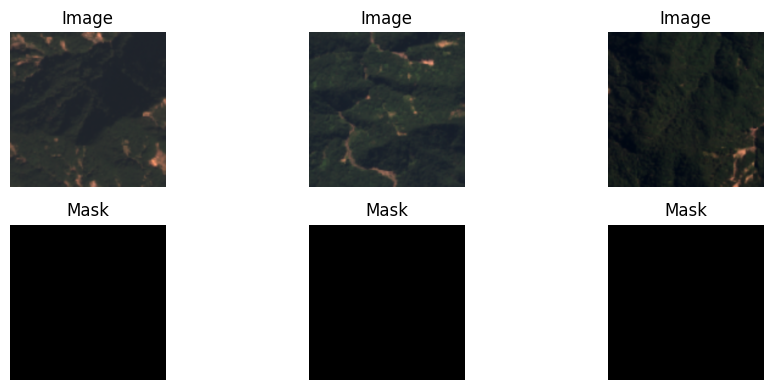

In [44]:
for images, masks in train_ds.take(1):
    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, 3, i+4)
        plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [45]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)):
    inputs = layers.Input(shape=input_shape)

    # Smaller filters: 32, 64, 128, 256 instead of 64..1024
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = models.Model(inputs, outputs)
    return model
model = build_unet()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_46 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 256, 256,  │      9,248 │ re_lu_46[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_49[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_47 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ re_lu_47[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_50[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_48 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_48[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_51[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_49 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ re_lu_49[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_52[0][0] 

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [46]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def binary_focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1-1e-6)
        bce = -(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))
        pt = tf.where(y_true==1, y_pred, 1-y_pred)
        return tf.reduce_mean(alpha * (1-pt)**gamma * bce)
    return loss

def dice_focal_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + binary_focal_loss()(y_true, y_pred)


In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_focal_loss,
    metrics=[dice_coef]
)


In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_unet.h5",
        save_best_only=True,
        monitor="val_loss",
        mode="min"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=7, restore_best_weights=True, verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 7.7794e-12 - loss: 1.1676

33/33 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - dice_coef: 7.7988e-12 - loss: 1.1666 - val_dice_coef: 1.0200e-11 - val_loss: 1.1290 - learning_rate: 1.0000e-04
Epoch 2/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 9.5049e-12 - loss: 1.0721

33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - dice_coef: 9.5261e-12 - loss: 1.0719 - val_dice_coef: 1.0842e-11 - val_loss: 1.1044 - learning_rate: 1.0000e-04
Epoch 3/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.1244e-11 - loss: 1.0411

33/33 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - dice_coef: 1.1265e-11 - loss: 1.0410 - val_dice_coef: 1.2036e-11 - val_loss: 1.0742 - learning_rate: 1.0000e-04
Epoch 4/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.2717e-11 - loss: 1.0281

33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - dice_coef: 1.2743e-11 - loss: 1.0280 - val_dice_coef: 1.3432e-11 - val_loss: 1.0515 - learning_rate: 1.0000e-04
Epoch 5/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.4174e-11 - loss: 1.0197

33/33 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - dice_coef: 1.4201e-11 - loss: 1.0196 - val_dice_coef: 1.4751e-11 - val_loss: 1.0377 - learning_rate: 1.0000e-04
Epoch 6/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.5532e-11 - loss: 1.0148

33/33 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - dice_coef: 1.5554e-11 - loss: 1.0148 - val_dice_coef: 1.6583e-11 - val_loss: 1.0269 - learning_rate: 1.0000e-04
Epoch 7/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.6646e-11 - loss: 1.0116

33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - dice_coef: 1.6658e-11 - loss: 1.0116 - val_dice_coef: 1.7880e-11 - val_loss: 1.0208 - learning_rate: 1.0000e-04
Epoch 8/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - dice_coef: 1.7318e-11 - loss: 1.0103

33/33 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - dice_coef: 1.7342e-11 - loss: 1.0103 - val_dice_coef: 1.9665e-11 - val_loss: 1.0157 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


In [55]:
test_loss, test_dice= model.evaluate(val_ds)
print("Test loss :", test_loss)
print("Test Dice :", test_dice)
# print("Test IoU  :", test_iou)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 716ms/step - dice_coef: 1.5639e-11 - loss: 1.0157
Test loss : 1.0156968832015991
Test Dice : 1.9598064490700118e-11
Test IoU  : 0.04313382878899574


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


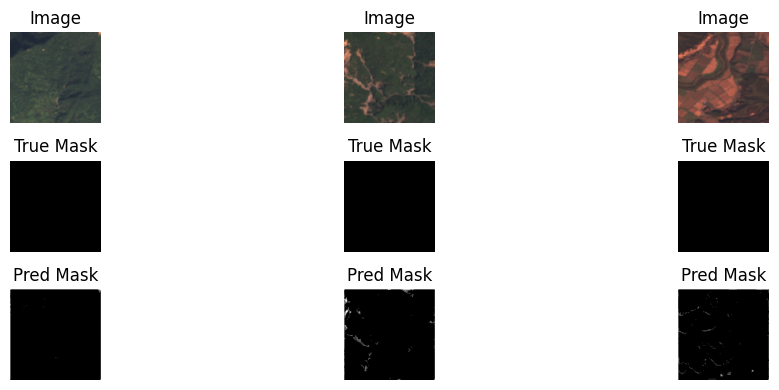

In [56]:
# Take one batch from test set
for imgs, true_masks in test_ds.take(1):
    preds = model.predict(imgs)
    preds_bin = (preds > 0.3).astype(np.float32)

    n = min(3, imgs.shape[0])
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Image
        plt.subplot(3, n, i+1)
        plt.imshow(imgs[i])
        plt.title("Image")
        plt.axis("off")

        # True mask
        plt.subplot(3, n, i+1+n)
        plt.imshow(true_masks[i].numpy().squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(preds_bin[i].squeeze(), cmap="gray")
        plt.title("Pred Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
